# Load libraries, configuration

In [62]:
import os
import json

import tensorflow as tf
import keras
from keras import backend as K
#from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import numpy as np

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Configs

In [63]:
user = 'participant1'
interval = '15min'

columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 
           'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Include FonLog data
# columns += ['time_from_last_drug_taken'] #, 'wo_duration']

# Additional data
columns += ['timestamp_dayofweek', 'timestamp_hour_sin', 'timestamp_hour_cos']

# 'wearing_off' | 'wearing_off_post_meds' | 'wearing_off_lead60'
target_column = 'wearing_off' 
columns.append(target_column)

participant_dictionary = json.load(open(f'./data/participant_dictionary.json'))

# CV splits
if interval == '15min':
    record_size_per_day = 96
elif interval == '15s':
    record_size_per_day = 5760
elif interval == '1min':
    record_size_per_day = 1440

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
#       BalancedSparseCategoricalAccuracy(),
#       BalancedAccuracy()]

BATCH_SIZE = 1
MAX_EPOCHS = 10
LEARNING_RATE = 1e-3
SHIFT = 4 # 1 = 15 min, 2 = 30 min, 4 = 1 hour
MULTI_STEP_WIDTH = 36 # input 36 = 9 hours, input 96 = 24 hours
USE_HOURLY = False
SAVEFIG = False
EXPERIMENT_NAME = 'with wearing-off'
REMOVE_WEARING_OFF_IN_PREVIOUS_STEP = False

# features to normalize
# timestamp_dayofweek, wearing_off were not normalized
normalize_features = ['heart_rate', 'steps', 'stress_score', 'awake', 'deep', 
                      'light', 'rem', 'nonrem_total', 'total', 'nonrem_percentage',
                      'sleep_efficiency', 'timestamp_hour_sin', 'timestamp_hour_cos']
def normalize_data(df, mean, std, normalize_features=normalize_features):
    df_to_normalize = df.copy()
    df_to_normalize.loc[:, normalize_features] = ((
        df_to_normalize.loc[:, normalize_features] - mean
    ) / std)
    
    return df_to_normalize

# Load & process data

In [64]:
# dataset = pd.read_excel(f'./data/4-combined_data_{user}_{interval}.xlsx',
#                               index_col="timestamp",
#                               usecols=columns,
#                               engine='openpyxl')
# # Fill missing data with 0
# dataset.fillna(0, inplace=True)

# # Filter data based on participants' dictionary
# dataset = dataset.loc[
#     (dataset.index >= participant_dictionary[user]['start_date']) &
#     (dataset.index < participant_dictionary[user]['end_date_plus_two'])
# ]

# column_indices = { name: i for i, name in enumerate(dataset.columns) }
# df = dataset

In [65]:
combined_dataset = None
for participant_number in range(1,11):
    user = f'participant{participant_number}'
    dataset = pd.read_excel(f'./data/4-combined_data_{user}_{interval}.xlsx',
                                  index_col="timestamp",
                                  usecols=columns,
                                  engine='openpyxl')
        
    # Fill missing data with 0
    dataset.fillna(0, inplace=True)

    # Filter data based on participants' dictionary
    dataset = dataset.loc[
        (dataset.index >= participant_dictionary[user]['start_date']) &
        (dataset.index < participant_dictionary[user]['end_date_plus_two'])
    ]
    combined_dataset = pd.concat([combined_dataset, dataset])

dataset = combined_dataset
column_indices = { name: i for i, name in enumerate(dataset.columns) }
df = dataset

# Split dataset

In [66]:
# training data 60% 
TRAINING_PERCENTAGE = 0.6
# validation data 20%
VALIDATION_PERCENTAGE = 0.2

column_indices = { name: i for i, name in enumerate(df.columns) }
total_rows = len(df)
num_features = len(df.columns)

training_end_index = int(total_rows * TRAINING_PERCENTAGE)
validation_end_index = int(total_rows * (TRAINING_PERCENTAGE + VALIDATION_PERCENTAGE))

train_df = df[0:training_end_index].copy()
val_df = df[training_end_index:validation_end_index].copy()
test_df = df[validation_end_index:].copy()

print(f"Training data: {round(len(train_df)/record_size_per_day, 3)} days")
print(f"Validation data: {round(len(val_df)/record_size_per_day, 3)} days")
print(f"Test data: {round(len(test_df)/record_size_per_day, 3)} days")
print(f"Total data: {round(len(df)/record_size_per_day, 3)} days")

Training data: 54.594 days
Validation data: 18.198 days
Test data: 18.208 days
Total data: 91.0 days


# Normalize dataset

C:\Users\Macky\AppData\Local\Temp\ipykernel_10660\1093691293.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


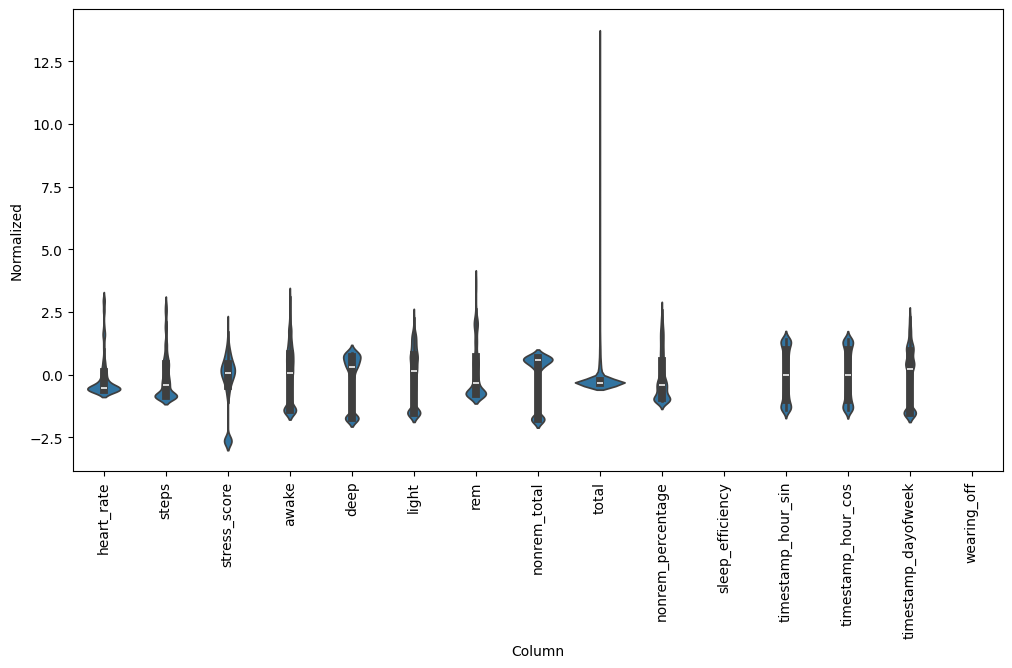

In [67]:
train_mean = train_df.loc[:, normalize_features].mean()
train_std = train_df.loc[:, normalize_features].std()

train_df = normalize_data(train_df, train_mean, train_std)
val_df = normalize_data(val_df, train_mean, train_std)
test_df = normalize_data(test_df, train_mean, train_std)

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# WindowGenerator

In [68]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
               label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')


  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        seed=4,
        batch_size=BATCH_SIZE,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

# Compile & Fit

In [69]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)

  # model.compile(loss=tf.keras.losses.MeanSquaredError(),
  #               optimizer=tf.keras.optimizers.Adam(),
  #               metrics=[tf.keras.metrics.MeanAbsoluteError()])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=METRICS)

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# CNN

In [70]:
# 96    24
# 24    6
CONV_WIDTH = MULTI_STEP_WIDTH
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['wearing_off'])

conv_window

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [36]
Label column name(s): ['wearing_off']

In [71]:
K.clear_session()
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(conv_model, conv_window)


Epoch 1/10
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9291 - auc: 0.4955 - fn: 192.9647 - fp: 0.0000e+00 - loss: 1.1443 - prc: 0.0694 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 2410.5352 - tp: 0.0000e+00 - val_accuracy: 0.9509 - val_auc: 0.5000 - val_fn: 84.0000 - val_fp: 0.0000e+00 - val_loss: 0.7913 - val_prc: 0.0491 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1627.0000 - val_tp: 0.0000e+00
Epoch 2/10
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9291 - auc: 0.4988 - fn: 193.0154 - fp: 0.0000e+00 - loss: 1.1425 - prc: 0.0709 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 2410.4844 - tp: 0.0000e+00 - val_accuracy: 0.9509 - val_auc: 0.5000 - val_fn: 84.0000 - val_fp: 0.0000e+00 - val_loss: 0.7913 - val_prc: 0.0491 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1627.0000 - val_tp: 0.0000e+00
Epoch 3/10
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9286 - auc: 0.4999 - fn: 193.0463 - fp: 0.0000e+00 - lo

In [72]:
IPython.display.clear_output()
print('validation')
print(conv_model.evaluate(conv_window.val))
print('test')
conv_model.evaluate(conv_window.test, verbose=0)

validation
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9487 - auc: 0.4947 - fn: 42.8014 - fp: 0.0000e+00 - loss: 0.8266 - prc: 0.0513 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 813.6980 - tp: 0.0000e+00
[0.7913029193878174, 0.0, 0.0, 1627.0, 84.0, 0.9509059190750122, 0.0, 0.0, 0.5, 0.049094099551439285]
test


[0.4519093930721283,
 0.0,
 0.0,
 1664.0,
 48.0,
 0.9719626307487488,
 0.0,
 0.0,
 0.5,
 0.028037382289767265]

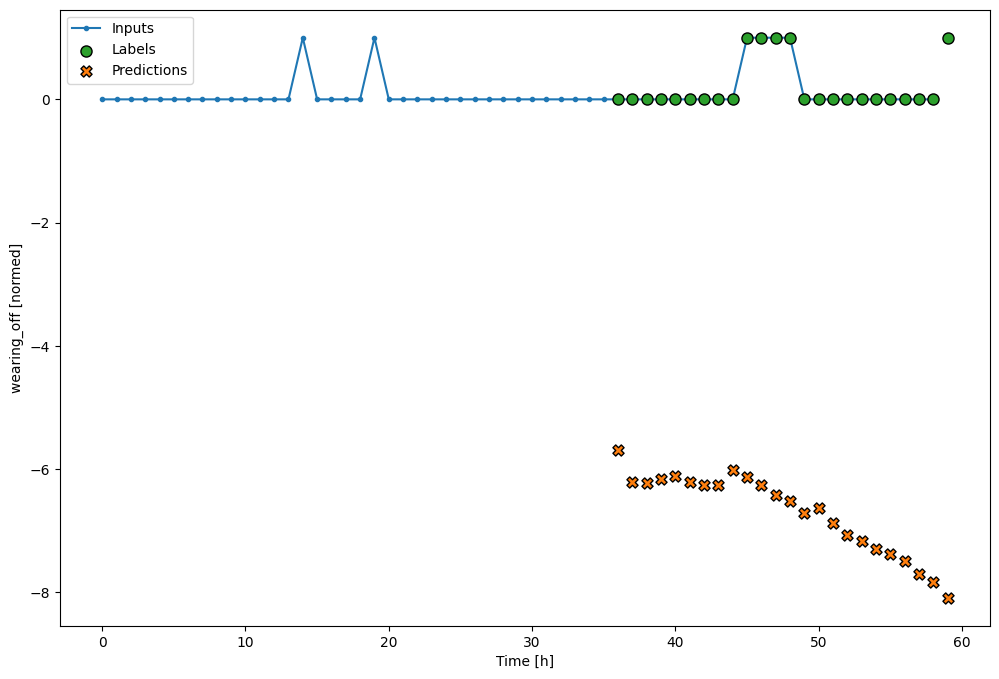

In [73]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['wearing_off'])

wide_conv_window.plot(conv_model, plot_col='wearing_off')

In [74]:
for_testing_df = test_df.iloc[-25:, :]

for_testing_mean = for_testing_df.mean()
for_testing_std = for_testing_df.std()

for_testing_df = (for_testing_df - for_testing_mean) / for_testing_std

In [75]:
for input, label in conv_window.make_dataset(for_testing_df):
    print(conv_model.predict(input))

In [76]:
for input, label in conv_window.make_dataset(test_df.iloc[0:25, :]):
    print(conv_model.predict(input))

In [77]:
def data_loader(new_df):
    return np.array(new_df, dtype=np.float32)[np.newaxis, ...]

# Multi-step

In [78]:
CONV_WIDTH = MULTI_STEP_WIDTH
OUT_STEPS = SHIFT
multi_window = WindowGenerator(input_width=MULTI_STEP_WIDTH,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['wearing_off']
                              )
multi_window

Total window size: 40
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [36 37 38 39]
Label column name(s): ['wearing_off']

In [79]:
K.clear_session()
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          activation='sigmoid',
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, -1])


    # tf.keras.layers.Conv1D(filters=64,
    #                        kernel_size=(MULTI_STEP_WIDTH,),
    #                        activation='relu'),
    # tf.keras.layers.Dense(units=64, activation='relu'),
    # tf.keras.layers.Dense(units=4, activation='sigmoid', name="output"),
])

history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/10
5202/5202 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9468 - auc: 0.7133 - fn: 771.7911 - fp: 47.1426 - loss: 0.2647 - prc: 0.1875 - precision: 0.2875 - recall: 0.0306 - tn: 11264.0732 - tp: 36.9923 - val_accuracy: 0.8129 - val_auc: 0.5139 - val_fn: 260.0000 - val_fp: 1018.0000 - val_loss: 0.8328 - val_prc: 0.0538 - val_precision: 0.0686 - val_recall: 0.2239 - val_tn: 5479.0000 - val_tp: 75.0000
Epoch 2/10
5202/5202 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.9349 - auc: 0.8228 - fn: 604.4990 - fp: 63.5735 - loss: 0.2073 - prc: 0.4139 - precision: 0.7241 - recall: 0.1920 - tn: 9583.7314 - tp: 156.1953 - val_accuracy: 0.8576 - val_auc: 0.4964 - val_fn: 270.0000 - val_fp: 703.0000 - val_loss: 0.7680 - val_prc: 0.0712 - val_precision: 0.0846 - val_recall: 0.1940 - val_tn: 5794.0000 - val_tp: 65.0000
Epoch 3/10
5202/5202 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9386 - auc: 0.8701 - fn: 542.6308 - fp: 82.2270 - loss: 0.1830 - prc: 0.5004 - precision: 0.7308 - recal

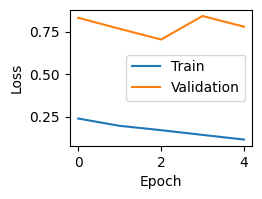

In [80]:
metrics = ['loss']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,3,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    # if metric == 'loss':
    #   plt.ylim([0, plt.ylim()[1]])
    # elif metric == 'auc':
    #   plt.ylim([0.8,1])
    # else:
    #   plt.ylim([0,1])
    plt.legend();

In [81]:
IPython.display.clear_output()
print('validation')
print(multi_conv_model.evaluate(multi_window.val))
print('test')
for name, value in zip(multi_conv_model.metrics_names, multi_conv_model.evaluate(multi_window.test, verbose=0)):
  print(name, ': ', value)
  print()

validation
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9297 - auc: 0.5227 - fn: 151.0281 - fp: 87.7970 - loss: 0.7118 - prc: 0.0897 - precision: 0.1953 - recall: 0.1317 - tn: 3162.4541 - tp: 18.7185
[0.7045366764068604, 32.0, 174.0, 6323.0, 303.0, 0.9301815032958984, 0.1553398072719574, 0.09552238881587982, 0.516029417514801, 0.06826156377792358]
test
loss :  0.38529014587402344

compile_metrics :  32.0



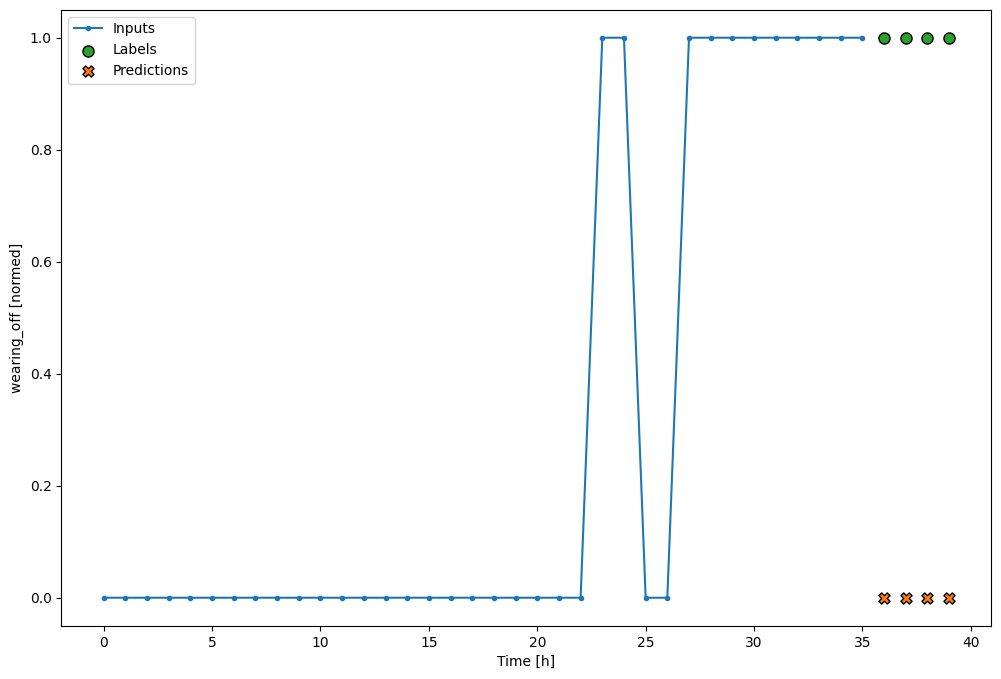

In [82]:
multi_window.plot(multi_conv_model, plot_col='wearing_off')

In [83]:
multi_window.example[0].numpy().shape

(1, 36, 15)

In [84]:
(multi_conv_model.predict(
    multi_window.example[0].numpy()
)[0,:4] * 100).round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


array([[0.  ],
       [0.03],
       [0.  ],
       [0.  ]], dtype=float32)

In [85]:
#predict前はshapeが(1,36,15)だが、predict後はshapeが(1,4,1)になりうまくいかない

#(multi_conv_model.predict(
#    multi_window.example[0].numpy()
#)[0,:,14] * 100).round(2).tolist()

In [86]:
multi_conv_model.predict(data_loader(train_df.iloc[0:36, :]))[0,:4]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([[0.7863305 ],
       [0.0731186 ],
       [0.01837808],
       [0.00668499]], dtype=float32)

In [87]:
multi_conv_model.predict(data_loader(test_df.iloc[0:36, :]))[0,:4]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[2.41175394e-06],
       [1.16865485e-05],
       [6.70147756e-07],
       [1.71623606e-06]], dtype=float32)

In [88]:
data_loader(train_df.iloc[0:96, :]).tolist()

[[[-2.6417076587677,
   -0.3356546461582184,
   -1.0234624147415161,
   -0.5977555513381958,
   -0.8702458739280701,
   -1.4258097410202026,
   -0.7849510312080383,
   -1.5299015045166016,
   -1.5272287130355835,
   -1.7396907806396484,
   -1.778692603111267,
   -0.0076278927735984325,
   1.4151312112808228,
   3.0,
   0.0],
  [-2.6417076587677,
   -0.3356546461582184,
   -1.0234624147415161,
   -0.5977555513381958,
   -0.8702458739280701,
   -1.4258097410202026,
   -0.7849510312080383,
   -1.5299015045166016,
   -1.5272287130355835,
   -1.7396907806396484,
   -1.778692603111267,
   0.08492494374513626,
   1.412105679512024,
   3.0,
   0.0],
  [-0.05412235110998154,
   -0.3356546461582184,
   -1.0012258291244507,
   -0.5977555513381958,
   -0.8702458739280701,
   -1.4258097410202026,
   -0.7849510312080383,
   -1.5299015045166016,
   -1.5272287130355835,
   -1.7396907806396484,
   -1.778692603111267,
   0.17708145081996918,
   1.403041958808899,
   3.0,
   0.0],
  [0.03733868896961212,

In [89]:
train_df.iloc[0:36, :]

,heart_rate,steps,stress_score,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency,timestamp_hour_sin,timestamp_hour_cos,timestamp_dayofweek,wearing_off
timestamp,,,,,,,,,,,,,,,
2021-11-25 00:00:00,-2.641708,-0.335655,-1.023462,-0.597756,-0.870246,-1.42581,-0.784951,-1.529901,-1.527229,-1.739691,-1.778693,-0.007628,1.415131,3,0
2021-11-25 00:15:00,-2.641708,-0.335655,-1.023462,-0.597756,-0.870246,-1.42581,-0.784951,-1.529901,-1.527229,-1.739691,-1.778693,0.084925,1.412106,3,0
2021-11-25 00:30:00,-0.054122,-0.335655,-1.001226,-0.597756,-0.870246,-1.42581,-0.784951,-1.529901,-1.527229,-1.739691,-1.778693,0.177081,1.403042,3,0
2021-11-25 00:45:00,0.037339,-0.335655,-0.526843,-0.597756,-0.870246,-1.42581,-0.784951,-1.529901,-1.527229,-1.739691,-1.778693,0.268447,1.387979,3,0
2021-11-25 01:00:00,0.471779,-0.335655,-1.023462,-0.597756,-0.870246,-1.42581,-0.784951,-1.529901,-1.527229,-1.739691,-1.778693,0.358630,1.366981,3,0
2021-11-25 01:15:00,-2.641708,-0.335655,-1.023462,-0.597756,-0.870246,-1.42581,-0.784951,-1.529901,-1.527229,-1.739691,-1.778693,0.447245,1.340139,3,0
2021-11-25 01:30:00,-2.641708,-0.335655,-1.023462,-0.597756,-0.870246,-1.42581,-0.784951,-1.529901,-1.527229,-1.739691,-1.778693,0.533913,1.307566,3,0
2021-11-25 01:45:00,-2.641708,-0.335655,-1.023462,-0.597756,-0.870246,-1.42581,-0.784951,-1.529901,-1.527229,-1.739691,-1.778693,0.618261,1.269403,3,0
2021-11-25 02:00:00,-2.641708,-0.335655,-1.023462,-0.597756,-0.870246,-1.42581,-0.784951,-1.529901,-1.527229,-1.739691,-1.778693,0.699929,1.225813,3,0


# Export Model

In [96]:
base_path = "models"
model_version = "2"
model_name = "multi_conv_model"
model_path = os.path.join(base_path, model_name, model_version)
tf.saved_model.save(multi_conv_model, model_path)

FailedPreconditionError: models\multi_conv_model\2\variables is not a directory

In [ ]:
saved_model = tf.saved_model.load(model_path)

In [ ]:
saved_model(data_loader(test_df.iloc[0:36, :]), training=False)[:,:,14]

In [ ]:
saved_model(data_loader(test_df.iloc[0:24, :]).tolist(), training=False)[:,:,14]

In [ ]:
print(data_loader(test_df.iloc[0:36, :]).tolist())

In [ ]:
data_loader(test_df.iloc[0:36, :]).shape